In [1]:
%matplotlib inline
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from ComplexLayers_Torch import Beam_Classifier, eval_model
import torch.utils.data
import torch.nn as nn
from sklearn.model_selection import train_test_split
from beam_utils import ULA_DFT_codebook as DFT_codebook
from beam_utils import plot_codebook_pattern, DFT_angles, Beam_Search_Tree, get_AMCF_codebook, AMCF_boundaries

/home/ziyi/anaconda3/envs/ziyiPytorch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(7)
# number of probing beams (N_W)
n_wide_beams = [6, 10, 14, 18]
# n_wide_beams = [6]
# number of narrow data beams to select from (N_V)
n_nb = 128
n_antenna = 64
batch_size = 500

noise_power_dBm = -94
noise_factor = -13 #dB

noiseless = False

In [3]:
dataset_name = 'Rosslyn_ULA'
h_real = np.load('./Dataset/Rosslyn/MISO_Static_FineGrid_Hmatrices_real.npy')
h_imag = np.load('./Dataset/Rosslyn/MISO_Static_FineGrid_Hmatrices_imag.npy')
tx_power_dBm = 10

if noiseless:
    noise_power_dBm = -np.inf    
noise_power = 10**((noise_power_dBm-tx_power_dBm-noise_factor)/10)

h = h_real + 1j*h_imag
valid_ue_idc = np.array([row_idx for (row_idx,row) in enumerate(np.concatenate((h_real, h_imag), axis = 1)) if not all(row == 0)])
h = h[valid_ue_idc]
h_real = h_real[valid_ue_idc]
h_imag = h_imag[valid_ue_idc]
norm_factor = np.max(abs(h))
h_scaled = h/norm_factor
h_concat_scaled = np.concatenate((h_real/norm_factor, h_imag/norm_factor), axis = 1)

train_idc, test_idc = train_test_split(np.arange(h.shape[0]), test_size = 0.4)
val_idc, test_idc = train_test_split(test_idc, test_size = 0.5)

In [4]:
learnable_codebook_acc = []
learnable_codebook_topk_acc = []
learned_codebook_topk_gain= []

optimal_gains = []          # maximum softlabel index
learned_codebooks = []
dft_codebooks = []


In [5]:
for n_wb_i, n_wb in enumerate(n_wide_beams):
    print('{} Wide Beams, {} Narrow Beams.'.format(n_wb, n_nb))
    dft_nb_codebook = DFT_codebook(nseg = n_nb,n_antenna = n_antenna)
    label = np.argmax(np.power(np.absolute(np.matmul(h_scaled, dft_nb_codebook.conj().T)), 2), axis = 1)
    soft_label = np.power(np.absolute(np.matmul(h, dft_nb_codebook.conj().T)), 2)

    x_train, y_train = h_concat_scaled[train_idc, :], label[train_idc]
    x_val, y_val = h_concat_scaled[val_idc, :], label[val_idc]
    x_test, y_test = h_concat_scaled[test_idc, :], label[test_idc]
    
    torch_x_train,torch_y_train = torch.from_numpy(x_train), torch.from_numpy(y_train)
    torch_x_val,torch_y_val = torch.from_numpy(x_val), torch.from_numpy(y_val)
    torch_x_test,torch_y_test = torch.from_numpy(x_test), torch.from_numpy(y_test)
    
    # Pytorch train and test sets
    train = torch.utils.data.TensorDataset(torch_x_train, torch_y_train)
    val = torch.utils.data.TensorDataset(torch_x_val, torch_y_val)
    test = torch.utils.data.TensorDataset(torch_x_test, torch_y_test)
    
    # data loader
    train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
    val_loader = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = False)
    test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
    
    learnable_codebook_model = Beam_Classifier(n_antenna  = n_antenna,
                                               n_wide_beam = n_wb,
                                               n_narrow_beam = n_nb,
                                               trainable_codebook = True,
                                               noise_power = noise_power,
                                               norm_factor = norm_factor)

    learnable_model_savefname = '/home/ziyi/Documents/python/Backup/LSSP/LSSP-20221111/Dataset/Rosslyn/SaveModel/{}_trainable_{}_beam_probing_codebook_{}_beam_classifier_noise_{}_dBm.pt'.format(dataset_name,n_wb,n_nb,noise_power_dBm)
    learnable_codebook_model.load_state_dict(torch.load(learnable_model_savefname))                                                                                   
    
    learnable_codebook_test_loss, learnable_codebook_test_acc = eval_model(learnable_codebook_model, test_loader, nn.CrossEntropyLoss()) 
    learnable_codebook_acc.append(learnable_codebook_test_acc)

    y_test_predict_learnable_codebook = learnable_codebook_model(torch_x_test.float()).detach().numpy()
    topk_sorted_test_learned_codebook = (-y_test_predict_learnable_codebook).argsort()  # the order of them  (why minus?)
    # argsort!!!   small -large
    topk_bf_gain_learnable_codebook = []
    topk_acc_learnable_codebook = []

    for ue_bf_gain, pred_sort in zip(soft_label[test_idc, :], topk_sorted_test_learned_codebook):
        topk_gains = [ue_bf_gain[pred_sort[:k]].max() for k in range(1, 11)]     # here!! quit strange
        topk_bf_gain_learnable_codebook.append(topk_gains)                       # 
        topk_acc = [ue_bf_gain.argmax() in pred_sort[:k] for k in range(1, 11)]
        topk_acc_learnable_codebook.append(topk_acc)
        
    topk_bf_gain_learnable_codebook = np.array(topk_bf_gain_learnable_codebook)
    learned_codebook_topk_gain.append(topk_bf_gain_learnable_codebook)
    learned_codebooks.append(learnable_codebook_model.get_codebook()) 
    topk_acc_learnable_codebook = np.array(topk_acc_learnable_codebook).mean(axis=0)
    learnable_codebook_topk_acc.append(topk_acc_learnable_codebook)

    optimal_gains.append(soft_label[test_idc,:].max(axis=-1))

6 Wide Beams, 128 Narrow Beams.
10 Wide Beams, 128 Narrow Beams.
14 Wide Beams, 128 Narrow Beams.
18 Wide Beams, 128 Narrow Beams.


In [6]:
learned_codebook_topk_gain = np.array(learned_codebook_topk_gain)

optimal_gains = np.array(optimal_gains)

learned_codebook_topk_snr = tx_power_dBm + 10*np.log10(learned_codebook_topk_gain) - noise_power_dBm + noise_factor
optimal_snr = tx_power_dBm + 10*np.log10(optimal_gains) - noise_power_dBm + noise_factor

learnable_codebook_topk_acc = np.array(learnable_codebook_topk_acc)

compute exhaustive beam search acc and snr

In [7]:
dft_nb_codebook = DFT_codebook(nseg = 128, n_antenna = 64)
# dft_nb_az = DFT_angles(128)
# dft_nb_az = np.arcsin(1/0.5*dft_nb_az)

nb_bf_signal = np.matmul(h[test_idc], dft_nb_codebook.conj().T)     # without AWGN
nb_bf_noise_real = np.random.normal(loc = 0, scale = 1, size = nb_bf_signal.shape)*np.sqrt(noise_power/2)
nb_bf_noise_imag = np.random.normal(loc = 0, scale = 1, size = nb_bf_signal.shape)*np.sqrt(noise_power/2)
nb_bf_signal_with_noise = nb_bf_signal + nb_bf_noise_real + 1j*nb_bf_noise_imag

nb_bf_gain = np.power(np.absolute(nb_bf_signal), 2)     # power without AWGN
best_nb = np.argmax(nb_bf_gain, axis = 1)
nb_bf_gain_with_noise = np.power(np.absolute(nb_bf_signal_with_noise), 2)   # power with AWGN
best_nb_noisy = np.argmax(nb_bf_gain_with_noise, axis = 1)

# best_nb_az = dft_nb_az[best_nb]         # corresponding azimuth of the best narrow beam
exhaustive_acc = (best_nb_noisy == best_nb).mean()      # corruption caused by noise
genie_nb_snr = tx_power_dBm + 10*np.log10(nb_bf_gain.max(axis = 1)) - noise_power_dBm + noise_factor

# best narrow beam index in noisy case -> beamforming gain in noiseless case  (for each user grid)
exhaustive_nb_snr = np.array([nb_bf_gain[ue_idx, best_nb_idx_noisy] for ue_idx, best_nb_idx_noisy in enumerate(best_nb_noisy)])     # size: num_ue x 1
exhaustive_nb_snr = tx_power_dBm + 10*np.log10(exhaustive_nb_snr) - noise_power_dBm + noise_factor

# without wide beam, so just a number
print('Genie avg. SNR = {} dB.'.format(genie_nb_snr.mean()))
print('Exhaustive search accuracy = {}, avg. SNR = {} dB.'.format(exhaustive_acc,exhaustive_nb_snr.mean()))

Genie avg. SNR = 19.442021870061694 dB.
Exhaustive search accuracy = 0.8763729246487867, avg. SNR = 19.208690078294403 dB.


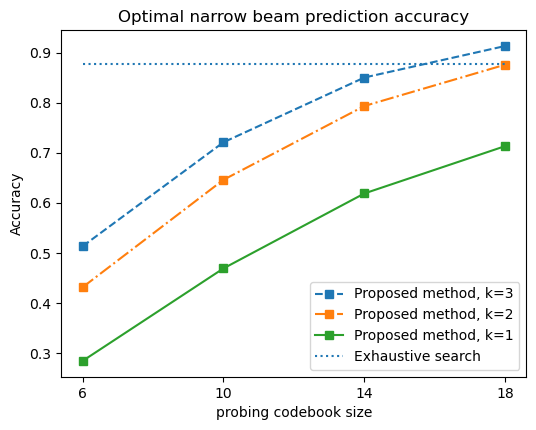

In [8]:
fig1 = plt.figure(num = 1, figsize = (6,4.5))
ax1 = fig1.add_subplot(111)
ax1.plot(n_wide_beams, learnable_codebook_topk_acc[:, 2], '--',marker = 's', label = 'Proposed method, k={}'.format(3))
ax1.plot(n_wide_beams, learnable_codebook_topk_acc[:, 1], '-.',marker = 's', label = 'Proposed method, k={}'.format(2))
ax1.plot(n_wide_beams, learnable_codebook_topk_acc[:, 0], marker = 's', label = 'Proposed method, k={}'.format(1))
plt.hlines(y = exhaustive_acc, xmin = min(n_wide_beams), xmax = max(n_wide_beams), linestyles = 'dotted', label = 'Exhaustive search')
plt.xticks(n_wide_beams)
plt.legend()
plt.xlabel('probing codebook size')
plt.ylabel('Accuracy')
plt.title('Optimal narrow beam prediction accuracy')
plt.show()


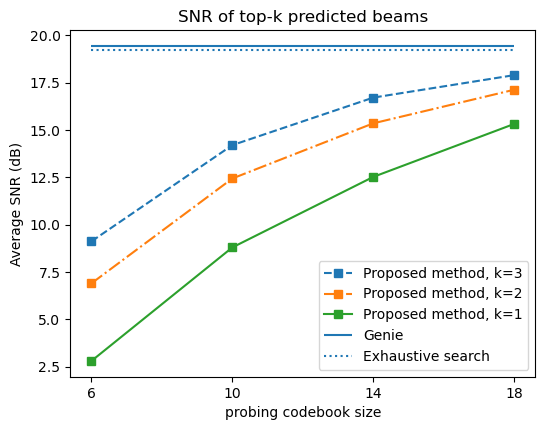

In [9]:
fig2 = plt.figure(num = 1, figsize = (6, 4.5))
ax2 = fig2.add_subplot(111)
ax2.plot(n_wide_beams, learned_codebook_topk_snr[:, :, 2].mean(axis = 1), '--',marker = 's', label = 'Proposed method, k={}'.format(3))
ax2.plot(n_wide_beams, learned_codebook_topk_snr[:, :, 1].mean(axis = 1), '-.',marker = 's', label = 'Proposed method, k={}'.format(2))
ax2.plot(n_wide_beams, learned_codebook_topk_snr[:, :, 0].mean(axis = 1), marker = 's', label = 'Proposed method, k={}'.format(1))
plt.hlines(y = genie_nb_snr.mean(), xmin = min(n_wide_beams), xmax = max(n_wide_beams), linestyles = 'solid', label = 'Genie')
plt.hlines(y = exhaustive_nb_snr.mean(), xmin = min(n_wide_beams), xmax = max(n_wide_beams), linestyles = 'dotted', label = 'Exhaustive search')
plt.xticks(n_wide_beams)
plt.legend()
plt.xlabel('probing codebook size')
plt.ylabel('Average SNR (dB)')
plt.title('SNR of top-k predicted beams')
plt.show()